# Traffic sign recognition

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import timm
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np



# Data Agumention

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.RandomRotation(20), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

In [3]:
# Load your data
train_dataset = datasets.ImageFolder(root='../../main_dataset/train', transform=transform)
val_dataset = datasets.ImageFolder(root='../../main_dataset/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model Architecture

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc4 = nn.Linear(hidden_dim//2, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)  
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim)
        self.batchnorm2 = nn.BatchNorm1d(hidden_dim//2)  

    def forward(self, x):
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)  

        x = self.fc2(x)
        x = self.batchnorm1(x)  
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.batchnorm2(x) 
        x = self.relu(x)
        x = self.dropout(x) 
        
        x = self.fc4(x)
        
        return x

    

In [5]:
# Load pre-trained MobileNet model
model = timm.create_model('mobilevitv2_075.cvnets_in1k', pretrained=True)
num_classes = len(train_dataset.classes)

# Replace the classifier layer
model.head.fc = MLP(model.head.fc.in_features, 512, num_classes)

# Check if CUDA is available and get the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

ByobNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (stages): Sequential(
    (0): Sequential(
      (0): BottleneckBlock(
        (conv1_1x1): ConvNormAct(
          (conv): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
        )
        (conv2_kxk): ConvNormAct(
          (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn): BatchNormAct2d(
            48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
   

In [6]:
print(train_dataset.classes)

['front_or_left', 'front_or_right', 'hump', 'left_turn', 'narro_from_lef', 'narrows_from_right', 'no_horron', 'no_parking', 'no_u_turn', 'overtaking_is_forbidden', 'parking', 'pedestrian_crossing', 'right_or_left', 'right_turn', 'rotor', 'slow', 'speed_100', 'speed_30', 'speed_40', 'speed_50', 'speed_60', 'speed_80', 'stop', 'u_turn']


# Compile  model

In [7]:

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

# Define the best accuracy
best_accuracy = 0
epsilon = 1e-5
epochs = 100


# train the head of the network

In [8]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
print('Start training...')
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'models/best.pt')

    lr_scheduler.step(avg_val_loss)
# Save the last model
torch.save(model.state_dict(), 'models/last.pt')


Start training...
Epoch 1, Train Loss: 2.7831, Train Accuracy: 23.60%, Val Loss: 2.6211, Val Accuracy: 41.57%
Epoch 2, Train Loss: 1.9483, Train Accuracy: 55.77%, Val Loss: 2.1000, Val Accuracy: 65.05%
Epoch 3, Train Loss: 1.3869, Train Accuracy: 70.99%, Val Loss: 1.6458, Val Accuracy: 77.83%
Epoch 4, Train Loss: 0.9767, Train Accuracy: 79.44%, Val Loss: 1.3365, Val Accuracy: 84.66%
Epoch 5, Train Loss: 0.6887, Train Accuracy: 84.52%, Val Loss: 1.0430, Val Accuracy: 87.25%
Epoch 6, Train Loss: 0.5107, Train Accuracy: 87.16%, Val Loss: 0.8303, Val Accuracy: 90.19%
Epoch 7, Train Loss: 0.3979, Train Accuracy: 89.13%, Val Loss: 0.7229, Val Accuracy: 92.80%
Epoch 8, Train Loss: 0.3075, Train Accuracy: 92.34%, Val Loss: 0.5856, Val Accuracy: 95.57%
Epoch 9, Train Loss: 0.2198, Train Accuracy: 95.18%, Val Loss: 0.4618, Val Accuracy: 97.27%
Epoch 10, Train Loss: 0.1585, Train Accuracy: 96.51%, Val Loss: 0.3608, Val Accuracy: 98.00%
Epoch 11, Train Loss: 0.1190, Train Accuracy: 97.60%, Val Los

# accuracy & loss curves

In [9]:
from sklearn.metrics import accuracy_score
# Generating predictions for the test dataset
test_dataset = datasets.ImageFolder(root='../../main_dataset/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
class_names = test_dataset.classes
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
print(f'test_accuracy:{accuracy_score(all_labels, all_preds)}%')


test_accuracy:0.9972785001511945%


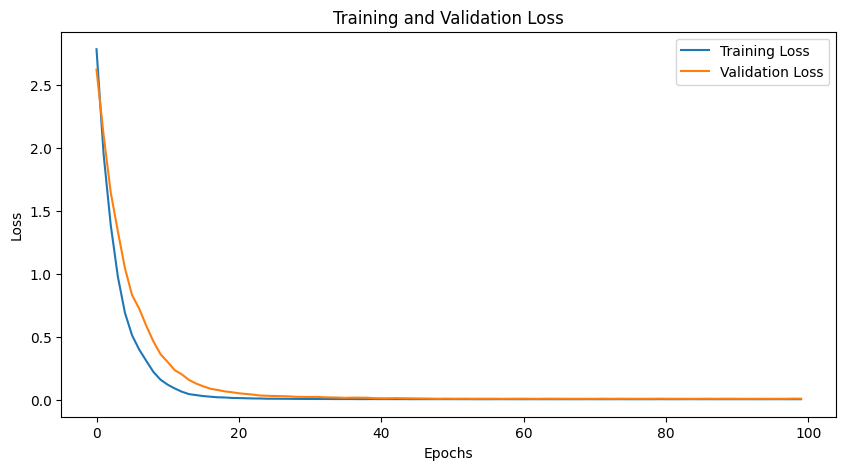

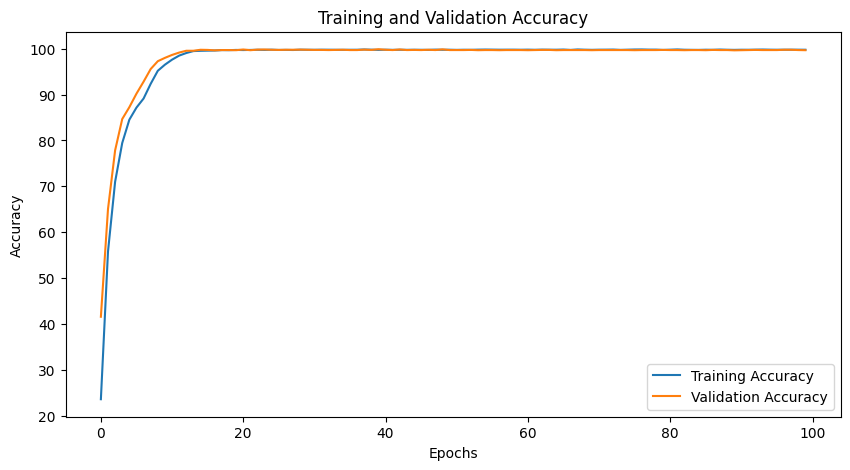

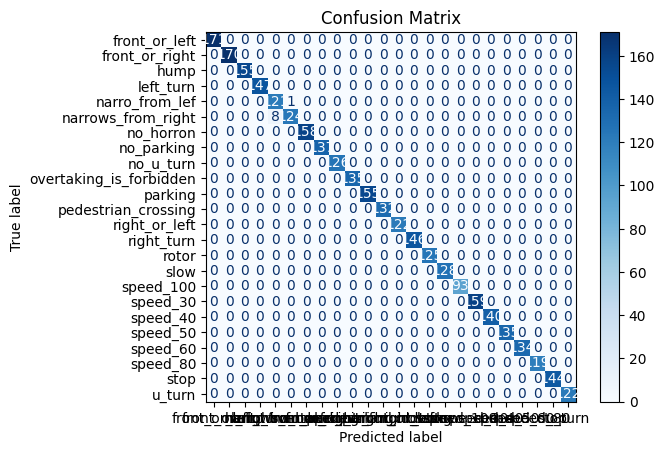

In [10]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Displaying the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
